In [1]:
import numpy as np
import pandas as pd
import scipy.signal as sg
from sklearn.preprocessing import StandardScaler
import random
import os
import pickle

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, utils, datasets  # %USERPROFILE%\.keras\datasets\
import matplotlib.pyplot as plt

In [2]:
address = r"IMU Dataset\Data"

optLen = 1054

learnRate = 1e-4
batchSize = 600
epoch = 200

sampleLen = 200
samplePerTrial = 5
features = 45
volunteers = 30
trainPortion = 0.8
valPortion = 0.1
testPortion = 0.1
classes = 5

trunk = 1
thighR = 2
thighL = 3
shankR = 4
shankL = 5
wrist = 6

norm = {'Acc_X': [-20.59292, 31.47302], 
        'Acc_Y': [-13.67152, 19.44969], 
        'Acc_Z': [-35.48537, 18.8095], 
        'Gyr_X': [-6.838557, 7.868352], 
        'Gyr_Y': [-16.90477, 16.61124], 
        'Gyr_Z': [-4.431263, 6.664771], 
        'Roll': [-207.2701, 214.6915], 
        'Pitch': [-89.953, 87.27671], 
        'Yaw': [-203.8373, 204.2526]}

In [3]:
def normalize_fixed(x, current_range, normed_range):
    current_min, current_max = current_range
    normed_min, normed_max = normed_range
    x_normed = (x - current_min) / (current_max - current_min)
    x_normed = x_normed * (normed_max - normed_min) + normed_min
    return x_normed

def trialLabel(num):
    if num in range(4, 10):
        return 0  # 'FE'
    if num in [16, 18, 20, 22, 24, 26]:
        return 1  # 'StrU'
    if num in [17, 19, 21, 23, 25, 27]:
        return 2  # 'StrD'
    if num in [28, 30, 32, 34, 36, 38]:
        return 3  # 'SlpU'
    if num in [29, 31, 33, 35, 37, 39]:
        return 4  # 'SlpD'
    print('Check dataset!')


def trialName(num):
    if num in range(4, 10):
        return 'FE: 0'
    if num in [16, 18, 20, 22, 24, 26]:
        return 'StrU: 1'
    if num in [17, 19, 21, 23, 25, 27]:
        return 'StrD: 2'
    if num in [28, 30, 32, 34, 36, 38]:
        return 'SlpU: 3'
    if num in [29, 31, 33, 35, 37, 39]:
        return 'SlpD: 4'
    return False


def trialInd(num):
    if num == 0:
        return 'FE: 0'
    if num == 1:
        return 'StrU: 1'
    if num == 2:
        return 'StrD: 2'
    if num == 3:
        return 'SlpU: 3'
    if num == 4:
        return 'SlpD: 4'
    return False


def openCSV(addr):
    df = pd.read_csv(addr, sep=',', header=None)
    header = df.iloc[0]
    df = pd.DataFrame(df[1:], dtype=float)
    df.columns = header
    return df

In [4]:
try:
    with open('data', 'rb') as f:
        data = pickle.load(f)
        
except:
    data = []
    for person in range(1, volunteers + 1):
        t = []
        print(person, "out of 30")
        for trial in range(1, 58):
            s = []
            for sensor in range(1, 7):
                s.append(openCSV(address + 'person{}_trial{}_sensor{}.csv'.format(person, trial, sensor)))
            t.append(s)
        data.append(t)

    with open('data', 'ab') as f:
        pickle.dump(data, f)

In [5]:
dic = {'Acc_X': [1e10, -1e10], 'Acc_Y': [1e10, -1e10], 'Acc_Z': [1e10, -1e10],
        'Gyr_X': [1e10, -1e10], 'Gyr_Y': [1e10, -1e10], 'Gyr_Z': [1e10, -1e10], 
        'Roll': [1e10, -1e10], 'Pitch': [1e10, -1e10], 'Yaw': [1e10, -1e10]}

for person in range(0, volunteers):
    for trial in list(range(3, 9)) + list(range(15, 39)):
        flag = False
        for i in range(samplePerTrial):
            for sample in range(i * sampleLen, sampleLen + i * sampleLen):
                for sensor in range(1, 5):
                    if flag:
                        break
                    if len(data[person][trial][sensor]) < optLen:
                        flag = True
                        continue
                    for para in ['Acc_X', 'Acc_Y', 'Acc_Z', 
                                'Gyr_X', 'Gyr_Y', 'Gyr_Z', 
                                'Roll', 'Pitch', 'Yaw']:
                        if data[person][trial][sensor][para].values[sample] > dic[para][1]:
                            dic[para][1] = data[person][trial][sensor][para].values[sample]
                        elif data[person][trial][sensor][para].values[sample] < dic[para][0]:
                            dic[para][0] = data[person][trial][sensor][para].values[sample]

print(dic)

{'Acc_X': [-20.59292, 31.47302], 'Acc_Y': [-13.67152, 19.44969], 'Acc_Z': [-35.48537, 18.8095], 'Gyr_X': [-6.838557, 7.868352], 'Gyr_Y': [-16.90477, 16.61124], 'Gyr_Z': [-4.431263, 6.664771], 'Roll': [-207.2701, 214.6915], 'Pitch': [-89.953, 87.27671], 'Yaw': [-203.8373, 204.2526]}


In [16]:
ds = []
dsr = []
dsLbl = []
headers = []

for s in ('TR_', 'TL_', 'SR_', 'SL_'):
    for h in [f'{s}Acc_X', f'{s}Acc_Y', f'{s}Gyr_Y', f'{s}Gyr_Z', f'{s}Roll']:
        headers.append(h)

for person in range(0, volunteers):
    for trial in list(range(3, 9)) + list(range(15, 39)):
        flag = False
        for i in range(samplePerTrial):
            tmp = []
            tmpr = []
            for sample in range(i * sampleLen, sampleLen + i * sampleLen):
                tmp2 = []
                tmpr2 = []
                # tmp2.append(np.sin(np.pi * sample/42))
                for sensor in range(0, 5):
                    if flag:
                        break
                    if len(data[person][trial][sensor]) < optLen:
                        flag = True
                        continue
                    for para in ['Acc_X', 'Acc_Y', 'Acc_Z', 
                                'Gyr_X', 'Gyr_Y', 'Gyr_Z', 
                                'Roll', 'Pitch', 'Yaw']:
                        rawData = data[person][trial][sensor][para].values[sample]
                        if not np.isfinite(rawData):
                            rawData = 0
                        normData = normalize_fixed(rawData, norm[para], [-1, 1])
                        tmp2.append(normData)
                        tmpr2.append(rawData)
                if flag:
                    break
                tmp.append(tmp2)
                tmpr.append(tmpr2)
            if flag:
                break
            ds.append(tmp)
            dsr.append(tmpr)
            dsLbl.append(int(trialLabel(trial + 1)))
            
print(len(ds))

4270


Epoch 1/200
346/346 [==============================] - 2s 6ms/step - loss: 1.5815 - accuracy: 0.3605 - val_loss: 1.1683 - val_accuracy: 0.8073
Epoch 2/200
346/346 [==============================] - 2s 5ms/step - loss: 1.0510 - accuracy: 0.6606 - val_loss: 0.7628 - val_accuracy: 0.8099
Epoch 3/200
346/346 [==============================] - 2s 5ms/step - loss: 0.6909 - accuracy: 0.8011 - val_loss: 0.6792 - val_accuracy: 0.7943
Epoch 4/200
346/346 [==============================] - 2s 5ms/step - loss: 0.5028 - accuracy: 0.8361 - val_loss: 0.6793 - val_accuracy: 0.7995
Epoch 5/200
346/346 [==============================] - 2s 5ms/step - loss: 0.4056 - accuracy: 0.8526 - val_loss: 0.6775 - val_accuracy: 0.8047
Epoch 6/200
346/346 [==============================] - 2s 5ms/step - loss: 0.3336 - accuracy: 0.8768 - val_loss: 0.6074 - val_accuracy: 0.7995
Epoch 7/200
346/346 [==============================] - 2s 5ms/step - loss: 0.2983 - accuracy: 0.8855 - val_loss: 0.7121 - val_accuracy: 0.8099

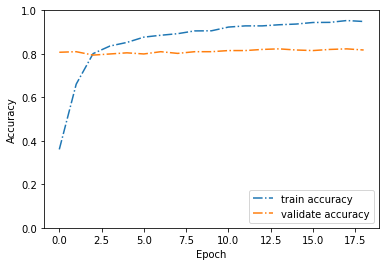

Epoch 1/200
346/346 [==============================] - 3s 9ms/step - loss: 0.4890 - accuracy: 0.7930 - val_loss: 0.5510 - val_accuracy: 0.7656
Epoch 2/200
346/346 [==============================] - 3s 8ms/step - loss: 0.4027 - accuracy: 0.8086 - val_loss: 0.5381 - val_accuracy: 0.7656
Epoch 3/200
346/346 [==============================] - 3s 8ms/step - loss: 0.3586 - accuracy: 0.8335 - val_loss: 0.5569 - val_accuracy: 0.7786
Epoch 4/200
346/346 [==============================] - 3s 8ms/step - loss: 0.3135 - accuracy: 0.8615 - val_loss: 0.5308 - val_accuracy: 0.8281
Epoch 5/200
346/346 [==============================] - 3s 8ms/step - loss: 0.2677 - accuracy: 0.8852 - val_loss: 0.8340 - val_accuracy: 0.7812
Epoch 6/200
346/346 [==============================] - 3s 8ms/step - loss: 0.2256 - accuracy: 0.9066 - val_loss: 1.0107 - val_accuracy: 0.7891
Epoch 7/200
346/346 [==============================] - 3s 8ms/step - loss: 0.1938 - accuracy: 0.9214 - val_loss: 1.0361 - val_accuracy: 0.8307

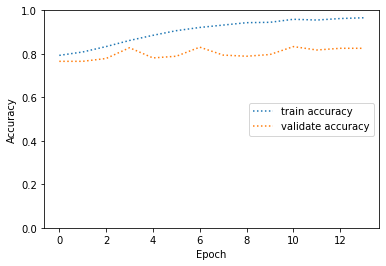

Epoch 1/200
312/312 [==============================] - 2s 7ms/step - loss: 1.5775 - accuracy: 0.3635 - val_loss: 1.1891 - val_accuracy: 0.7536
Epoch 2/200
312/312 [==============================] - 1s 5ms/step - loss: 1.0335 - accuracy: 0.6529 - val_loss: 0.7939 - val_accuracy: 0.7594
Epoch 3/200
312/312 [==============================] - 2s 5ms/step - loss: 0.6487 - accuracy: 0.7970 - val_loss: 0.6288 - val_accuracy: 0.7855
Epoch 4/200
312/312 [==============================] - 1s 5ms/step - loss: 0.4757 - accuracy: 0.8340 - val_loss: 0.5460 - val_accuracy: 0.8000
Epoch 5/200
312/312 [==============================] - 2s 5ms/step - loss: 0.4042 - accuracy: 0.8459 - val_loss: 0.5545 - val_accuracy: 0.7855
Epoch 6/200
312/312 [==============================] - 2s 5ms/step - loss: 0.3505 - accuracy: 0.8626 - val_loss: 0.5486 - val_accuracy: 0.7855
Epoch 7/200
312/312 [==============================] - 1s 5ms/step - loss: 0.3141 - accuracy: 0.8757 - val_loss: 0.4209 - val_accuracy: 0.8290

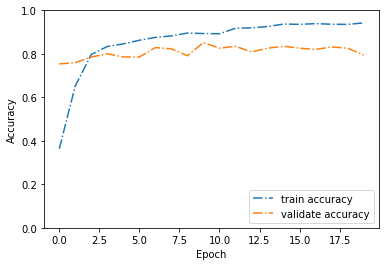

Epoch 1/200
312/312 [==============================] - 3s 11ms/step - loss: 0.4764 - accuracy: 0.8003 - val_loss: 0.4577 - val_accuracy: 0.8174
Epoch 2/200
312/312 [==============================] - 3s 8ms/step - loss: 0.3607 - accuracy: 0.8372 - val_loss: 0.4053 - val_accuracy: 0.8145
Epoch 3/200
312/312 [==============================] - 3s 8ms/step - loss: 0.3115 - accuracy: 0.8648 - val_loss: 0.4966 - val_accuracy: 0.7913
Epoch 4/200
312/312 [==============================] - 3s 8ms/step - loss: 0.2659 - accuracy: 0.8892 - val_loss: 0.5428 - val_accuracy: 0.8145
Epoch 5/200
312/312 [==============================] - 2s 8ms/step - loss: 0.2286 - accuracy: 0.9123 - val_loss: 0.5856 - val_accuracy: 0.8261
Epoch 6/200
312/312 [==============================] - 3s 9ms/step - loss: 0.1974 - accuracy: 0.9277 - val_loss: 0.8407 - val_accuracy: 0.7913
Epoch 7/200
312/312 [==============================] - 3s 9ms/step - loss: 0.1873 - accuracy: 0.9265 - val_loss: 0.9265 - val_accuracy: 0.814

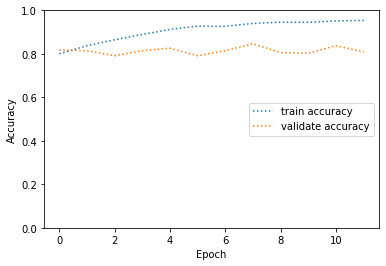

Epoch 1/200
281/281 [==============================] - 2s 7ms/step - loss: 1.7821 - accuracy: 0.3029 - val_loss: 1.3035 - val_accuracy: 0.8103
Epoch 2/200
281/281 [==============================] - 1s 5ms/step - loss: 1.2308 - accuracy: 0.5384 - val_loss: 0.7835 - val_accuracy: 0.8939
Epoch 3/200
281/281 [==============================] - 1s 5ms/step - loss: 0.8598 - accuracy: 0.7224 - val_loss: 0.4367 - val_accuracy: 0.9260
Epoch 4/200
281/281 [==============================] - 1s 5ms/step - loss: 0.6549 - accuracy: 0.7713 - val_loss: 0.3511 - val_accuracy: 0.9035
Epoch 5/200
281/281 [==============================] - 1s 5ms/step - loss: 0.5300 - accuracy: 0.8109 - val_loss: 0.3040 - val_accuracy: 0.9100
Epoch 6/200
281/281 [==============================] - 1s 5ms/step - loss: 0.4462 - accuracy: 0.8273 - val_loss: 0.2729 - val_accuracy: 0.9260
Epoch 7/200
281/281 [==============================] - 1s 5ms/step - loss: 0.4071 - accuracy: 0.8427 - val_loss: 0.2443 - val_accuracy: 0.9228

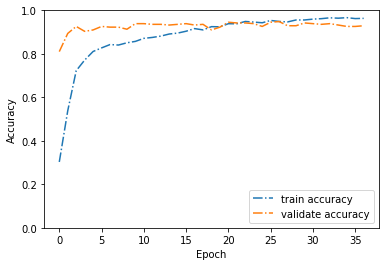

Epoch 1/200
281/281 [==============================] - 3s 11ms/step - loss: 0.5056 - accuracy: 0.7895 - val_loss: 0.2797 - val_accuracy: 0.8875
Epoch 2/200
281/281 [==============================] - 2s 8ms/step - loss: 0.4085 - accuracy: 0.8073 - val_loss: 0.2596 - val_accuracy: 0.8875
Epoch 3/200
281/281 [==============================] - 2s 9ms/step - loss: 0.3660 - accuracy: 0.8280 - val_loss: 0.2780 - val_accuracy: 0.8875
Epoch 4/200
281/281 [==============================] - 2s 9ms/step - loss: 0.3244 - accuracy: 0.8523 - val_loss: 0.2789 - val_accuracy: 0.8875
Epoch 5/200
281/281 [==============================] - 2s 9ms/step - loss: 0.2768 - accuracy: 0.8826 - val_loss: 0.2152 - val_accuracy: 0.9035
Epoch 6/200
281/281 [==============================] - 2s 8ms/step - loss: 0.2469 - accuracy: 0.8987 - val_loss: 0.2280 - val_accuracy: 0.9035
Epoch 7/200
281/281 [==============================] - 2s 9ms/step - loss: 0.2188 - accuracy: 0.9108 - val_loss: 0.2657 - val_accuracy: 0.903

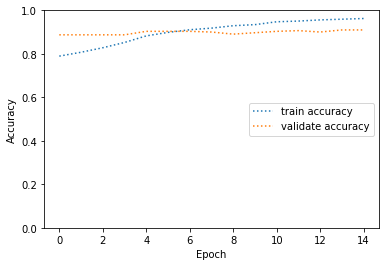

Epoch 1/200
253/253 [==============================] - 2s 6ms/step - loss: 1.7138 - accuracy: 0.3012 - val_loss: 1.2448 - val_accuracy: 0.8786
Epoch 2/200
253/253 [==============================] - 1s 5ms/step - loss: 1.1834 - accuracy: 0.5624 - val_loss: 0.7983 - val_accuracy: 0.8893
Epoch 3/200
253/253 [==============================] - 1s 5ms/step - loss: 0.8228 - accuracy: 0.7471 - val_loss: 0.6821 - val_accuracy: 0.8536
Epoch 4/200
253/253 [==============================] - 1s 5ms/step - loss: 0.6128 - accuracy: 0.8105 - val_loss: 0.3722 - val_accuracy: 0.8857
Epoch 5/200
253/253 [==============================] - 1s 5ms/step - loss: 0.5037 - accuracy: 0.8284 - val_loss: 0.3372 - val_accuracy: 0.8929
Epoch 6/200
253/253 [==============================] - 1s 5ms/step - loss: 0.4283 - accuracy: 0.8375 - val_loss: 0.2970 - val_accuracy: 0.9071
Epoch 7/200
253/253 [==============================] - 1s 5ms/step - loss: 0.3859 - accuracy: 0.8415 - val_loss: 0.2632 - val_accuracy: 0.9036

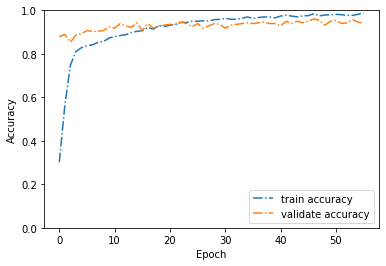

Epoch 1/200
253/253 [==============================] - 3s 11ms/step - loss: 0.5004 - accuracy: 0.7994 - val_loss: 0.2890 - val_accuracy: 0.8714
Epoch 2/200
253/253 [==============================] - 2s 9ms/step - loss: 0.3914 - accuracy: 0.8185 - val_loss: 0.2907 - val_accuracy: 0.8750
Epoch 3/200
253/253 [==============================] - 2s 8ms/step - loss: 0.3441 - accuracy: 0.8415 - val_loss: 0.2474 - val_accuracy: 0.8964
Epoch 4/200
253/253 [==============================] - 2s 9ms/step - loss: 0.3017 - accuracy: 0.8664 - val_loss: 0.2207 - val_accuracy: 0.8786
Epoch 5/200
253/253 [==============================] - 2s 8ms/step - loss: 0.2534 - accuracy: 0.8866 - val_loss: 0.2279 - val_accuracy: 0.8857
Epoch 6/200
253/253 [==============================] - 2s 8ms/step - loss: 0.2178 - accuracy: 0.9061 - val_loss: 0.2032 - val_accuracy: 0.8929
Epoch 7/200
253/253 [==============================] - 2s 9ms/step - loss: 0.1917 - accuracy: 0.9215 - val_loss: 0.1977 - val_accuracy: 0.907

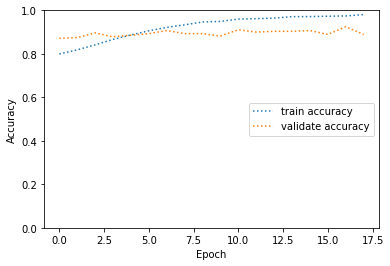

Epoch 1/200
228/228 [==============================] - 2s 8ms/step - loss: 1.8342 - accuracy: 0.2761 - val_loss: 1.2975 - val_accuracy: 0.9921
Epoch 2/200
228/228 [==============================] - 1s 5ms/step - loss: 1.3130 - accuracy: 0.4976 - val_loss: 0.9303 - val_accuracy: 1.0000
Epoch 3/200
228/228 [==============================] - 1s 5ms/step - loss: 0.8979 - accuracy: 0.7177 - val_loss: 0.6222 - val_accuracy: 0.9841
Epoch 4/200
228/228 [==============================] - 1s 5ms/step - loss: 0.5528 - accuracy: 0.9141 - val_loss: 0.3094 - val_accuracy: 1.0000
Epoch 5/200
228/228 [==============================] - 1s 6ms/step - loss: 0.3114 - accuracy: 0.9819 - val_loss: 0.1674 - val_accuracy: 1.0000
Epoch 6/200
228/228 [==============================] - 1s 6ms/step - loss: 0.1758 - accuracy: 0.9987 - val_loss: 0.0819 - val_accuracy: 1.0000
Epoch 7/200
228/228 [==============================] - 1s 6ms/step - loss: 0.1079 - accuracy: 0.9996 - val_loss: 0.0563 - val_accuracy: 1.0000

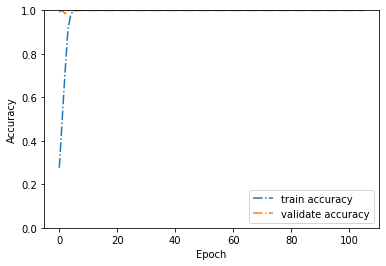

Epoch 1/200
228/228 [==============================] - 3s 12ms/step - loss: 0.0668 - accuracy: 0.9947 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 2/200
228/228 [==============================] - 2s 10ms/step - loss: 7.0911e-04 - accuracy: 1.0000 - val_loss: 5.5848e-04 - val_accuracy: 1.0000
Epoch 3/200
228/228 [==============================] - 2s 9ms/step - loss: 2.5900e-04 - accuracy: 1.0000 - val_loss: 2.6912e-04 - val_accuracy: 1.0000
Epoch 4/200
228/228 [==============================] - 2s 9ms/step - loss: 1.3201e-04 - accuracy: 1.0000 - val_loss: 1.5675e-04 - val_accuracy: 1.0000
Epoch 5/200
228/228 [==============================] - 2s 9ms/step - loss: 7.8752e-05 - accuracy: 1.0000 - val_loss: 1.0163e-04 - val_accuracy: 1.0000
Epoch 6/200
228/228 [==============================] - 2s 9ms/step - loss: 5.1610e-05 - accuracy: 1.0000 - val_loss: 7.0653e-05 - val_accuracy: 1.0000
Epoch 7/200
228/228 [==============================] - 2s 9ms/step - loss: 3.5914e-05 - accuracy: 1.

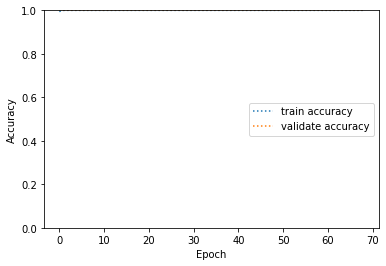

Epoch 1/200
205/205 [==============================] - 2s 8ms/step - loss: 1.8046 - accuracy: 0.2593 - val_loss: 1.3091 - val_accuracy: 1.0000
Epoch 2/200
205/205 [==============================] - 1s 5ms/step - loss: 1.3235 - accuracy: 0.4809 - val_loss: 0.9719 - val_accuracy: 1.0000
Epoch 3/200
205/205 [==============================] - 1s 6ms/step - loss: 0.8566 - accuracy: 0.7833 - val_loss: 0.6283 - val_accuracy: 1.0000
Epoch 4/200
205/205 [==============================] - 1s 5ms/step - loss: 0.4941 - accuracy: 0.9560 - val_loss: 0.2477 - val_accuracy: 1.0000
Epoch 5/200
205/205 [==============================] - 1s 5ms/step - loss: 0.2522 - accuracy: 0.9976 - val_loss: 0.1586 - val_accuracy: 1.0000
Epoch 6/200
205/205 [==============================] - 1s 6ms/step - loss: 0.1414 - accuracy: 1.0000 - val_loss: 0.0815 - val_accuracy: 1.0000
Epoch 7/200
205/205 [==============================] - 1s 6ms/step - loss: 0.0874 - accuracy: 1.0000 - val_loss: 0.0551 - val_accuracy: 1.0000

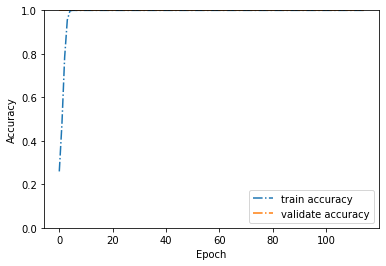

Epoch 1/200
205/205 [==============================] - 3s 12ms/step - loss: 0.0957 - accuracy: 0.9892 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 2/200
205/205 [==============================] - 2s 9ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 3.7735e-04 - val_accuracy: 1.0000
Epoch 3/200
205/205 [==============================] - 2s 9ms/step - loss: 3.6521e-04 - accuracy: 1.0000 - val_loss: 1.6577e-04 - val_accuracy: 1.0000
Epoch 4/200
205/205 [==============================] - 2s 9ms/step - loss: 1.7868e-04 - accuracy: 1.0000 - val_loss: 9.1577e-05 - val_accuracy: 1.0000
Epoch 5/200
205/205 [==============================] - 2s 9ms/step - loss: 1.0362e-04 - accuracy: 1.0000 - val_loss: 5.6901e-05 - val_accuracy: 1.0000
Epoch 6/200
205/205 [==============================] - 2s 9ms/step - loss: 6.6414e-05 - accuracy: 1.0000 - val_loss: 3.8345e-05 - val_accuracy: 1.0000
Epoch 7/200
205/205 [==============================] - 2s 9ms/step - loss: 4.5470e-05 - accuracy: 1.0000 

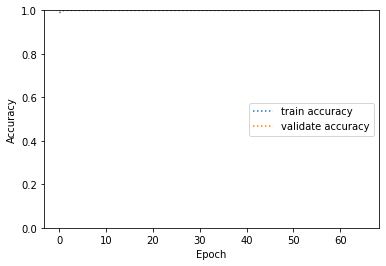

Epoch 1/200
184/184 [==============================] - 1s 7ms/step - loss: 1.8583 - accuracy: 0.2668 - val_loss: 1.3117 - val_accuracy: 1.0000
Epoch 2/200
184/184 [==============================] - 1s 4ms/step - loss: 1.4093 - accuracy: 0.4353 - val_loss: 0.9461 - val_accuracy: 1.0000
Epoch 3/200
184/184 [==============================] - 1s 4ms/step - loss: 0.9825 - accuracy: 0.6707 - val_loss: 0.4890 - val_accuracy: 1.0000
Epoch 4/200
184/184 [==============================] - 1s 4ms/step - loss: 0.6521 - accuracy: 0.8658 - val_loss: 0.3638 - val_accuracy: 1.0000
Epoch 5/200
184/184 [==============================] - 1s 4ms/step - loss: 0.4019 - accuracy: 0.9630 - val_loss: 0.2397 - val_accuracy: 1.0000
Epoch 6/200
184/184 [==============================] - 1s 4ms/step - loss: 0.2414 - accuracy: 0.9935 - val_loss: 0.1434 - val_accuracy: 1.0000
Epoch 7/200
184/184 [==============================] - 1s 4ms/step - loss: 0.1535 - accuracy: 0.9973 - val_loss: 0.0845 - val_accuracy: 1.0000

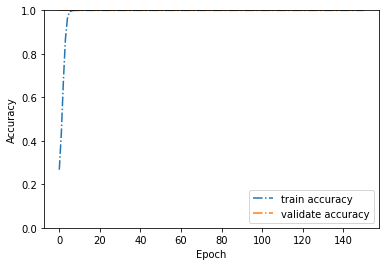

Epoch 1/200
184/184 [==============================] - 2s 12ms/step - loss: 0.1001 - accuracy: 0.9717 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 2/200
184/184 [==============================] - 1s 8ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 5.9807e-04 - val_accuracy: 1.0000
Epoch 3/200
184/184 [==============================] - 1s 8ms/step - loss: 4.3539e-04 - accuracy: 1.0000 - val_loss: 2.8577e-04 - val_accuracy: 1.0000
Epoch 4/200
184/184 [==============================] - 2s 8ms/step - loss: 2.3018e-04 - accuracy: 1.0000 - val_loss: 1.6509e-04 - val_accuracy: 1.0000
Epoch 5/200
184/184 [==============================] - 2s 8ms/step - loss: 1.4082e-04 - accuracy: 1.0000 - val_loss: 1.0599e-04 - val_accuracy: 1.0000
Epoch 6/200
184/184 [==============================] - 1s 8ms/step - loss: 9.4089e-05 - accuracy: 1.0000 - val_loss: 7.2997e-05 - val_accuracy: 1.0000
Epoch 7/200
184/184 [==============================] - 1s 8ms/step - loss: 6.6663e-05 - accuracy: 1.0000 

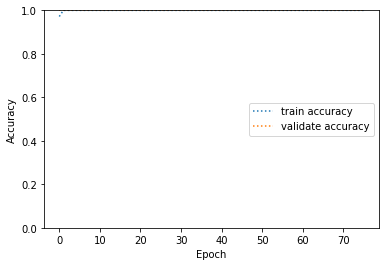

Epoch 1/200
166/166 [==============================] - 1s 7ms/step - loss: 1.8450 - accuracy: 0.2367 - val_loss: 1.3482 - val_accuracy: 1.0000
Epoch 2/200
166/166 [==============================] - 1s 5ms/step - loss: 1.4033 - accuracy: 0.4384 - val_loss: 1.0504 - val_accuracy: 1.0000
Epoch 3/200
166/166 [==============================] - 1s 5ms/step - loss: 1.0306 - accuracy: 0.6739 - val_loss: 0.6366 - val_accuracy: 1.0000
Epoch 4/200
166/166 [==============================] - 1s 4ms/step - loss: 0.7123 - accuracy: 0.8575 - val_loss: 0.4212 - val_accuracy: 1.0000
Epoch 5/200
166/166 [==============================] - 1s 6ms/step - loss: 0.4402 - accuracy: 0.9698 - val_loss: 0.2575 - val_accuracy: 1.0000
Epoch 6/200
166/166 [==============================] - 1s 5ms/step - loss: 0.2735 - accuracy: 0.9915 - val_loss: 0.1698 - val_accuracy: 1.0000
Epoch 7/200
166/166 [==============================] - 1s 5ms/step - loss: 0.1667 - accuracy: 0.9988 - val_loss: 0.0950 - val_accuracy: 1.0000

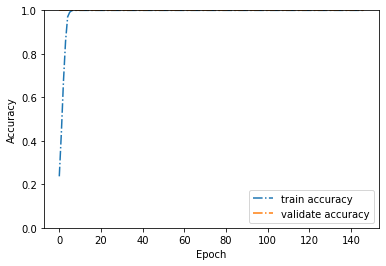

Epoch 1/200
166/166 [==============================] - 2s 13ms/step - loss: 0.0989 - accuracy: 0.9710 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 2/200
166/166 [==============================] - 2s 10ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 7.2989e-04 - val_accuracy: 1.0000
Epoch 3/200
166/166 [==============================] - 1s 9ms/step - loss: 4.5091e-04 - accuracy: 1.0000 - val_loss: 3.5731e-04 - val_accuracy: 1.0000
Epoch 4/200
166/166 [==============================] - 2s 10ms/step - loss: 2.3907e-04 - accuracy: 1.0000 - val_loss: 2.0895e-04 - val_accuracy: 1.0000
Epoch 5/200
166/166 [==============================] - 1s 8ms/step - loss: 1.4729e-04 - accuracy: 1.0000 - val_loss: 1.3678e-04 - val_accuracy: 1.0000
Epoch 6/200
166/166 [==============================] - 1s 9ms/step - loss: 9.9267e-05 - accuracy: 1.0000 - val_loss: 9.5766e-05 - val_accuracy: 1.0000
Epoch 7/200
166/166 [==============================] - 1s 8ms/step - loss: 7.0971e-05 - accuracy: 1.000

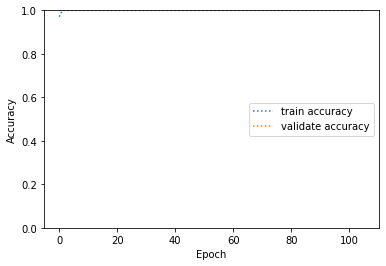

Epoch 1/200
150/150 [==============================] - 1s 7ms/step - loss: 1.8238 - accuracy: 0.2609 - val_loss: 1.3923 - val_accuracy: 1.0000
Epoch 2/200
150/150 [==============================] - 1s 5ms/step - loss: 1.4093 - accuracy: 0.4534 - val_loss: 1.1318 - val_accuracy: 1.0000
Epoch 3/200
150/150 [==============================] - 1s 5ms/step - loss: 1.0966 - accuracy: 0.6539 - val_loss: 0.7955 - val_accuracy: 1.0000
Epoch 4/200
150/150 [==============================] - 1s 5ms/step - loss: 0.7798 - accuracy: 0.8236 - val_loss: 0.5241 - val_accuracy: 1.0000
Epoch 5/200
150/150 [==============================] - 1s 4ms/step - loss: 0.5326 - accuracy: 0.9383 - val_loss: 0.3499 - val_accuracy: 1.0000
Epoch 6/200
150/150 [==============================] - 1s 4ms/step - loss: 0.3319 - accuracy: 0.9839 - val_loss: 0.2084 - val_accuracy: 1.0000
Epoch 7/200
150/150 [==============================] - 1s 5ms/step - loss: 0.2186 - accuracy: 0.9980 - val_loss: 0.1496 - val_accuracy: 1.0000

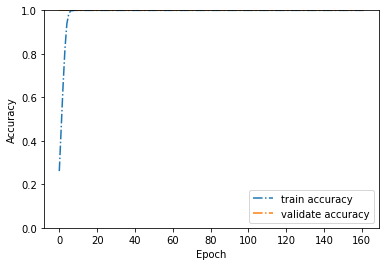

Epoch 1/200
150/150 [==============================] - 2s 12ms/step - loss: 0.1221 - accuracy: 0.9866 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 2/200
150/150 [==============================] - 1s 8ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 8.1611e-04 - val_accuracy: 1.0000
Epoch 3/200
150/150 [==============================] - 1s 8ms/step - loss: 5.6178e-04 - accuracy: 1.0000 - val_loss: 4.0640e-04 - val_accuracy: 1.0000
Epoch 4/200
150/150 [==============================] - 1s 8ms/step - loss: 2.8467e-04 - accuracy: 1.0000 - val_loss: 2.4339e-04 - val_accuracy: 1.0000
Epoch 5/200
150/150 [==============================] - 1s 8ms/step - loss: 1.6957e-04 - accuracy: 1.0000 - val_loss: 1.6038e-04 - val_accuracy: 1.0000
Epoch 6/200
150/150 [==============================] - 1s 8ms/step - loss: 1.1217e-04 - accuracy: 1.0000 - val_loss: 1.1488e-04 - val_accuracy: 1.0000
Epoch 7/200
150/150 [==============================] - 1s 8ms/step - loss: 7.9109e-05 - accuracy: 1.0000 

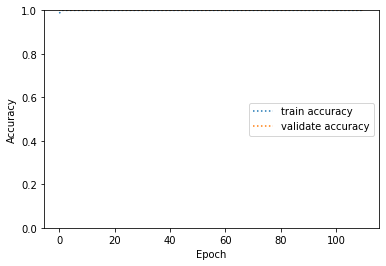

Epoch 1/200
135/135 [==============================] - 1s 7ms/step - loss: 1.8739 - accuracy: 0.2474 - val_loss: 1.4935 - val_accuracy: 0.9128
Epoch 2/200
135/135 [==============================] - 1s 4ms/step - loss: 1.5431 - accuracy: 0.3554 - val_loss: 1.2520 - val_accuracy: 1.0000
Epoch 3/200
135/135 [==============================] - 1s 5ms/step - loss: 1.1849 - accuracy: 0.5611 - val_loss: 0.8872 - val_accuracy: 1.0000
Epoch 4/200
135/135 [==============================] - 1s 6ms/step - loss: 0.8647 - accuracy: 0.7630 - val_loss: 0.6854 - val_accuracy: 1.0000
Epoch 5/200
135/135 [==============================] - 1s 7ms/step - loss: 0.5797 - accuracy: 0.9098 - val_loss: 0.3957 - val_accuracy: 1.0000
Epoch 6/200
135/135 [==============================] - 1s 5ms/step - loss: 0.3862 - accuracy: 0.9784 - val_loss: 0.3000 - val_accuracy: 1.0000
Epoch 7/200
135/135 [==============================] - 1s 5ms/step - loss: 0.2422 - accuracy: 0.9918 - val_loss: 0.1659 - val_accuracy: 1.0000

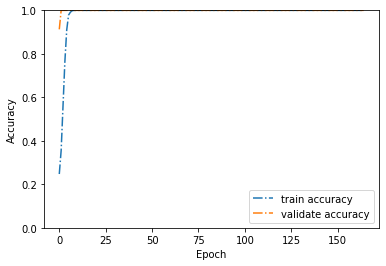

Epoch 1/200
135/135 [==============================] - 2s 13ms/step - loss: 0.0775 - accuracy: 0.9896 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 2/200
135/135 [==============================] - 1s 8ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 3/200
135/135 [==============================] - 1s 8ms/step - loss: 5.4154e-04 - accuracy: 1.0000 - val_loss: 5.4290e-04 - val_accuracy: 1.0000
Epoch 4/200
135/135 [==============================] - 1s 8ms/step - loss: 2.9937e-04 - accuracy: 1.0000 - val_loss: 3.3177e-04 - val_accuracy: 1.0000
Epoch 5/200
135/135 [==============================] - 1s 8ms/step - loss: 1.8854e-04 - accuracy: 1.0000 - val_loss: 2.2212e-04 - val_accuracy: 1.0000
Epoch 6/200
135/135 [==============================] - 1s 8ms/step - loss: 1.2903e-04 - accuracy: 1.0000 - val_loss: 1.5870e-04 - val_accuracy: 1.0000
Epoch 7/200
135/135 [==============================] - 1s 8ms/step - loss: 9.3361e-05 - accuracy: 1.0000 - va

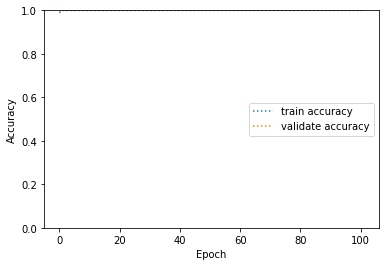

In [17]:
Accuracy = []

dsLbl1 = dsLbl

for cls in range(5):
    for i in range(len(dsLbl)):
        if dsLbl1[i] == cls:
            dsLbl1[i] = 1
        else:
            dsLbl1[i] = 0

    ds2 = tf.convert_to_tensor(ds,  dtype='float64')
    dsLbl2 = tf.one_hot(dsLbl1, 2)

    for k in [0, 5]:
        tmp = ds
        tmpLbl = dsLbl
        i = k / 10

        test = tmp[int(i * len(ds)):int((i + testPortion) * len(ds))]
        testLabel = tmpLbl[int(i * len(ds)):int((i + testPortion) * len(ds))]

        for _ in range(int(testPortion * len(ds))):
            tmp.pop(int(i * len(ds)))
            tmpLbl.pop(int(i * len(ds)))

        val = tmp[0:int(valPortion * len(ds))]
        valLabel = tmpLbl[0:int(valPortion * len(ds))]

        train = tmp[int(valPortion * len(ds)):]
        trainLabel = tmpLbl[int(valPortion * len(ds)):]


        test = tf.convert_to_tensor(test,  dtype='float64')
        testLabel = tf.one_hot(testLabel, classes)

        train = tf.convert_to_tensor(train,  dtype='float64')
        trainLabel = tf.one_hot(trainLabel, classes)

        val = tf.convert_to_tensor(val,  dtype='float64')
        valLabel = tf.one_hot(valLabel, classes)


        ### CNN

        model = models.Sequential()

        model.add(layers.Conv1D(18, 2, strides=2, activation=tf.nn.relu, input_shape=(sampleLen, features)))
        model.add(layers.MaxPooling1D(pool_size=2, strides=2))

        model.add(layers.Conv1D(36, 2, strides=2, activation=tf.nn.relu))
        model.add(layers.MaxPooling1D(pool_size=2, strides=1))

        model.add(layers.Conv1D(72, 2, strides=2, activation=tf.nn.relu))
        model.add(layers.MaxPooling1D(pool_size=2, strides=1))

        model.add(layers.Conv1D(144, 2, strides=2, activation=tf.nn.relu))
        model.add(layers.MaxPooling1D(pool_size=2, strides=2))

        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.5))

        model.add(layers.Flatten())
        model.add(layers.Dense(classes, activation='softmax'))


        model.compile(optimizer=optimizers.Adam(learning_rate=learnRate), metrics=['accuracy'],
                    loss=losses.CategoricalCrossentropy(from_logits=False))

        earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')

        history = model.fit(train, trainLabel, batch_size=10, epochs=epoch, 
                            shuffle=True, validation_data=(val, valLabel), 
                            callbacks=[earlyStop])


        plt.plot(history.history['accuracy'], '-.', label='train accuracy')
        plt.plot(history.history['val_accuracy'], '-.', label='validate accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0, 1])
        plt.legend(loc='lower right')

        # print(f"Accuracy: {model.evaluate(test, testLabel)[1] * 100:.2f}%")
        Accuracy.append(model.evaluate(test, testLabel)[1] * 100)
        plt.savefig(r"C:\Users\A R H\Desktop\CNN_" + str(i) + ".png")
        plt.show()


        ### LSTM
        model = models.Sequential()

        model.add(layers.LSTM(32, return_sequences=True, input_shape=(sampleLen, features)))

        model.add(layers.Flatten())

        model.add(layers.Dense(classes, activation='softmax'))


        model.compile(optimizer=optimizers.Adam(learning_rate=learnRate), 
                        metrics=['accuracy'],
                        loss=losses.CategoricalCrossentropy(from_logits=False))

        earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')

        history = model.fit(train, trainLabel, batch_size=10, epochs=epoch, 
                            shuffle=True, validation_data=(val, valLabel), 
                            callbacks=[earlyStop])


        plt.plot(history.history['accuracy'], ':', label='train accuracy')
        plt.plot(history.history['val_accuracy'], ':', label='validate accuracy')
        # plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
        # plt.plot(history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0, 1])
        plt.legend(loc='right')

        # print(f"Accuracy: {model.evaluate(test, testLabel)[1] * 100:.2f}%")
        Accuracy.append(model.evaluate(test, testLabel)[1] * 100)
        plt.savefig(r"C:\Users\A R H\Desktop\RNN_" + str(i) + ".png")
        plt.show()

In [18]:
Accuracy

[78.22014093399048,
 86.18267178535461,
 89.84375,
 86.71875,
 80.28985261917114,
 78.55072617530823,
 93.56912970542908,
 90.67524075508118,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0]